## Part 2 - The soft-rules

It may help to visualise the soft-rules by introducing some more gates to empthasise that we can 'choose' rather than take what we get

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pulp import *
import pickle

In [2]:
# Load previous
airport = pickle.load(open("airport.p", "rb"))
turns2 = pickle.load(open("turns2.p", "rb"))
occupancy = pickle.load(open("occupancy.p", "rb"))
heatmapdf = pickle.load(open("heatmapdf.p", "rb"))

In [3]:
def plot_gantt_chart(allocated_turns, lp_variable_outcomes, min_bucket=5):
    for alloc in lp_variable_outcomes:
        if lp_variable_outcomes[alloc].varValue:
            allocated_turns.set_value(allocated_turns['turn_no'] == alloc[0], 'gate', alloc[-1])
    time_series = pd.Series(True, index= pd.date_range(
            start=turns2.inbound_arrival.min(),
            end=turns2.outbound_departure.max(),
            freq=pd.offsets.Minute(min_bucket)))
    def trunc_ts(series):
        return time_series.truncate(series['inbound_arrival'], series['outbound_departure'])
    allocheatmapdf = allocated_turns.apply(trunc_ts, axis=1).T
    allocheatmapdf.columns = allocated_turns['turn_no'].get_values()
    allocheatmapdf = allocheatmapdf.fillna(0).astype(int)
    allocheatmapdf.index = allocheatmapdf.index.time
    for col in list(allocheatmapdf.columns):
        allocheatmapdf.loc[allocheatmapdf[col] > 0, col] = col
    allocheatmapdf.columns = allocated_turns['gate'].get_values()  
    trans = allocheatmapdf.T
    plt_df = trans.groupby(trans.index).sum()
    sns.set()
    plt.figure(figsize=(20, 10))
    g = sns.heatmap(plt_df, xticklabels=10, cmap='nipy_spectral')

In [4]:
# Let's add some more gates
extra_gates = pd.DataFrame({
    'terminal':['C','C','D','D','E','E','E','E','E','E','E','E','E'],
    'gate':['C3','C4','D1','E1','E2','E3','E4','E5','E6','E7','E8','E9','E10'],
    'max_size':[2,3,2,1,3,3,1,1,2,3,2,1,2]
    }, columns=['terminal', 'gate', 'max_size'])

airport2 = airport.append(extra_gates, ignore_index = True)

In [5]:
turn_list = turns2.turn_no.get_values()
gate_list = airport2.gate.get_values()

compatible_gates = {}
for idx, row in turns2.iterrows():
    gates_lst = airport2[airport2.max_size >= row.plane_size].gate.get_values()
    compatible_gates[row.turn_no] = gates_lst
    
# New gate list
gate_list

array(['A1', 'A2', 'A3', 'B1', 'C1', 'C2', 'C3', 'C4', 'D1', 'E1', 'E2',
       'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10'], dtype=object)

## Model F - Explicit Desires (want a certain terminal)

In [6]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                continue
                
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket

In [7]:
# Imagine we really like the E terminal and would prefer to use those gates
# Add all turns under those gates with a negative cost coefficient
neg_cost_coefficient = -5
prob += lpSum(neg_cost_coefficient*x[t, g] for t, g in x if g.startswith('E'))  

Status:  Optimal
Minimised Cost:  -50.0
Turn 6 assigned to gate E9
Turn 10 assigned to gate E8
Turn 2 assigned to gate E2
Turn 3 assigned to gate E8
Turn 8 assigned to gate E2
Turn 9 assigned to gate E4
Turn 7 assigned to gate E3
Turn 5 assigned to gate E5
Turn 4 assigned to gate E1
Turn 1 assigned to gate E8


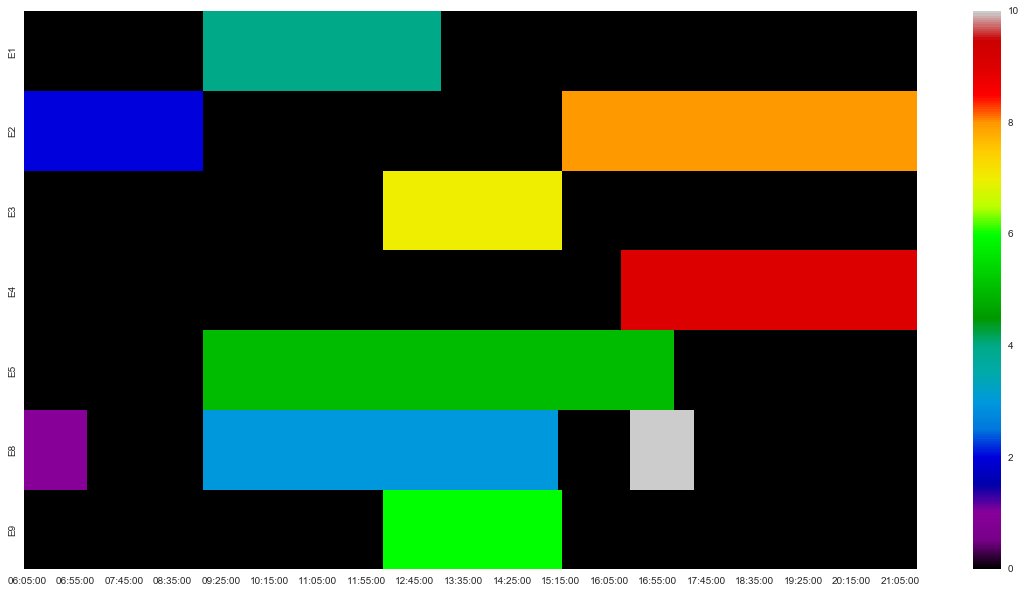

In [8]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

# We only get the desired 'E' gates
for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))  
        
# Visualise outcome
plot_gantt_chart(turns2, x)

## Model G - Minimise number of gates (Max Function)

Imagine that now we want to use as few gates as possible (and so ideally fit all flights to just one gate). We can introduce this into the model by using the max function, e.g.

`gate_A1_used = max(turn_1_to_A1, turn_2_to_A1, turn_3_to_A1, ...)`

And then adding gate_A1_used to the objective function with a positive coefficient. Because of the max() function the cost will only be incurred for the first flight to use the gate (and not the subsequent flights) and hence it will be preferred to pick a gate that can be used for another flight and another ... over one that can only be used for one flight.

To use max() in our linear programming model we notice that:

`gate_A1_used = max(A, B, C)`

is equivalent to:

`gate_A1_used >= A`

`gate_A1_used >= B`

`gate_A1_used >= C`

`gate_A1_used <= A + B + C`

We can add thus add these extra constraints to fit it into our **linear programming model**

In [9]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                continue
                
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket

In [10]:
gate_used_max = {}  # Dictionary to hold new variables

# Create the new variables
for g in gate_list:
        gate_used_max[g] = LpVariable("gate_%s_used" % g, 0, 1, LpBinary)
        # Gate_A1_used = max(turn_1_to_A1, turn_2_to_A1, turn_3_to_A1, ...)
        # Set lower-bound
        for t in turn_list:
            if (t, g) in x:
                prob += gate_used_max[g] >= x[t, g]
        # Set upper-bound
        prob += gate_used_max[g] <= lpSum(x[t, g] for t in turn_list if (t, g) in x)
        
                
# Add with positive coefficient to objective
pos_cost_coeff = 5
max_gates = lpSum(pos_cost_coeff*gate_used_max[g] for g in gate_used_max)

print(max_gates)
prob += max_gates

5*gate_A1_used + 5*gate_A2_used + 5*gate_A3_used + 5*gate_B1_used + 5*gate_C1_used + 5*gate_C2_used + 5*gate_C3_used + 5*gate_C4_used + 5*gate_D1_used + 5*gate_E10_used + 5*gate_E1_used + 5*gate_E2_used + 5*gate_E3_used + 5*gate_E4_used + 5*gate_E5_used + 5*gate_E6_used + 5*gate_E7_used + 5*gate_E8_used + 5*gate_E9_used


Status:  Optimal
Minimised Cost:  25.0
Turn 10 assigned to gate A1
Turn 7 assigned to gate E2
Turn 1 assigned to gate E2
Turn 4 assigned to gate C2
Turn 2 assigned to gate A1
Turn 5 assigned to gate E5
Turn 9 assigned to gate E2
Turn 6 assigned to gate A1
Turn 3 assigned to gate A3
Turn 8 assigned to gate C2


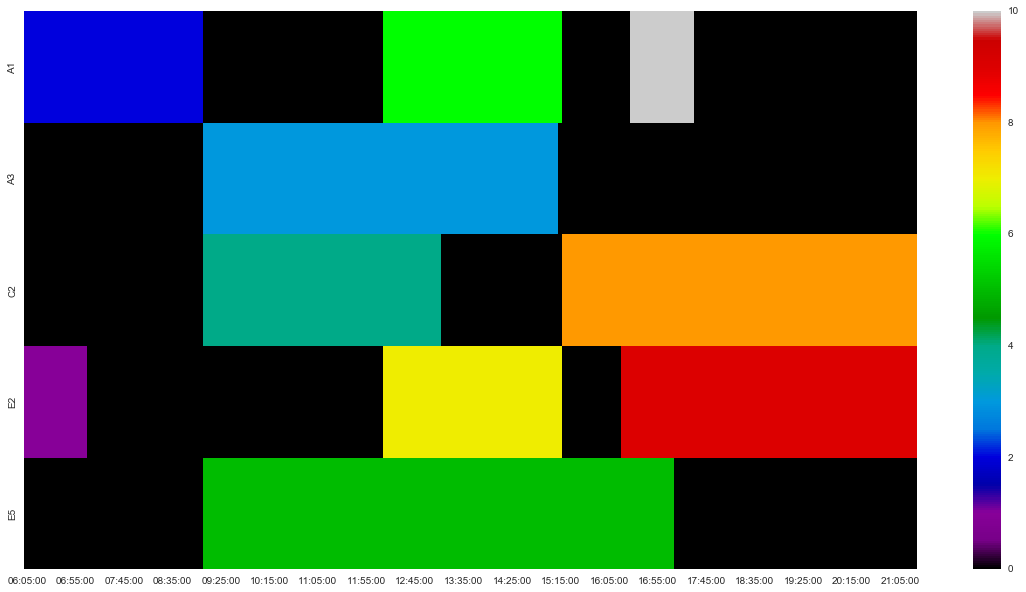

In [11]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))  

# This example uses just 5 gates (E5, A1, E9, E3, E10)
plot_gantt_chart(turns2, x)

## Model H - Maximise number of gates (Max Function)

We can accomplish the opposite just by flipping the coefficient and rewarding it for each new gate allocated

Status:  Optimal
Minimised Cost:  -50.0
Turn 1 assigned to gate A3
Turn 2 assigned to gate E7
Turn 5 assigned to gate E4
Turn 8 assigned to gate C1
Turn 10 assigned to gate C2
Turn 4 assigned to gate A2
Turn 3 assigned to gate C3
Turn 6 assigned to gate E8
Turn 9 assigned to gate E5
Turn 7 assigned to gate A1


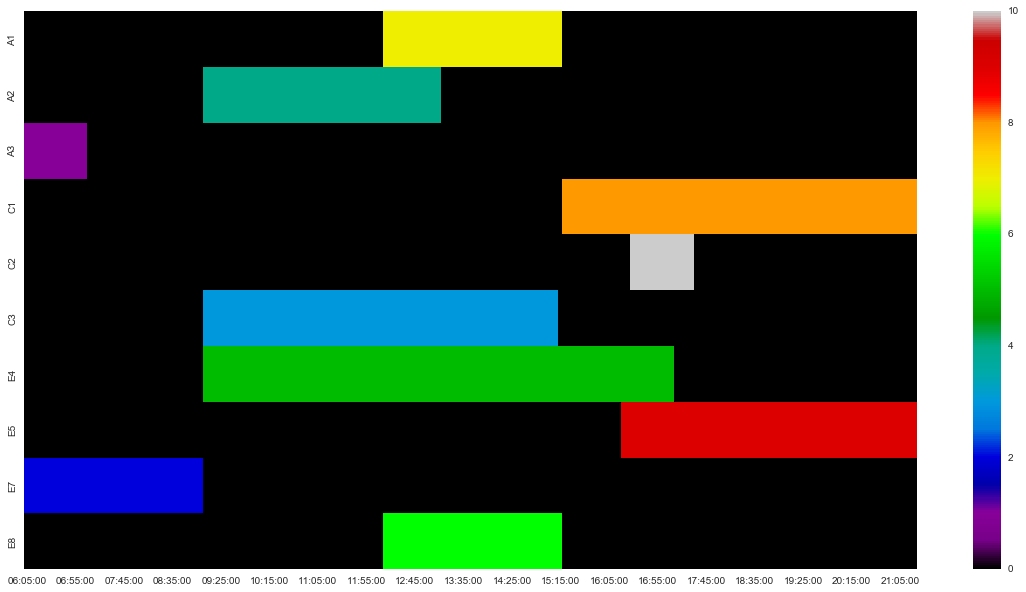

In [12]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                continue
                
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket
            
gate_used_max = {}  # Dictionary to hold new variables

# Create the new variables
for g in gate_list:
        gate_used_max[g] = LpVariable("gate_%s_used" % g, 0, 1, LpBinary)
        # Gate_A1_used = max(turn_1_to_A1, turn_2_to_A1, turn_3_to_A1, ...)
        # Set lower-bound
        for t in turn_list:
            if (t, g) in x:
                prob += gate_used_max[g] >= x[t, g]
        # Set upper-bound
        prob += gate_used_max[g] <= lpSum(x[t, g] for t in turn_list if (t, g) in x)
                
# Add with negative coefficient to objective
neg_cost_coeff = -5
max_gates = lpSum(neg_cost_coeff*gate_used_max[g] for g in gate_used_max)

prob += max_gates

# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))  

# This example uses all different gates for different turns
plot_gantt_chart(turns2, x)

## Model I - Connecting Flights (Min Function)

Imagine that turns 7 and 8 are connecting-flights and that we have lots of passengers going from turn 7 to turn 8. We may want to put them on the same terminal so that passengers don't have to travel very far. We don't really care which terminal it is as long as it can accommodate both of them.

We can create two variables for each terminal (imagine terminal A for now) like so:

`a = min(turn_7_to_A1, turn_7_to_A2, turn_7_to_A3, ...)`

`b = min(turn_8_to_A1, turn_8_to_A2, turn_8_to_A3, ...)`

`t7_t8_same_terminal_A = AND(a,b) = min(a,b)`

And then add them to objective function with a negative loss (because we want one of those to occur)

`objective += -10*t7_t8_same_terminal_A + -10*t7_t8_same_terminal_B + -10*t7_t8_same_terminal_B + ...`

The key is that we only want to get this negative loss if both turns take gates on the same terminal.

Just like with the Max function previously we can convert this into a linear-programming model:

`a = sum(turn_7_to_A1, turn_7_to_A2, turn_7_to_A3, ...)`

`b = sum(turn_8_to_A1, turn_8_to_A2, turn_8_to_A3, ...)`

Since we already have the constraint that a turn is only ever allocated to one gate the variables a and b will be either 0 or 1

Then to recreate the Min function:

`t7_t8_same_terminal_A >= a + b - 1`

`t7_t8_same_terminal_A <= a`

`t7_t8_same_terminal_A <= b`

So if either a or b is 0 then our new variable has to be equal to 0 (since it is binary and bounded to 0,1) and only if both are 1 do we get the condition:

`t7_t8_same_terminal_A >= 1 + 1 - 1`

`t7_t8_same_terminal_A >= 1`

Which can only be equal to 1 given the binary bounding

In [13]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                continue
                
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket

In [14]:
turn_connections = {} # Dictionary to hold new variables

list_of_turns_to_be_connected = [(7,8)]
list_of_terminals = airport2.terminal.unique()

for turn_i, turn_j in list_of_turns_to_be_connected:
    for airport_terminal in list_of_terminals:
        gates_in_terminal = airport2[airport2.terminal == airport_terminal].gate.unique()
        
        possible_allocations_i = [x[turn_i, gte] for gte in gates_in_terminal if (turn_i, gte) in x]
        possible_allocations_j = [x[turn_j, gte] for gte in gates_in_terminal if (turn_j, gte) in x]
        
        # If we have compatible gates in this terminal for both turns:
        if len(possible_allocations_i) and len(possible_allocations_j):
            a = lpSum(possible_allocations_i)
            b = lpSum(possible_allocations_j)
            
            # Create variable
            turn_connections[turn_i, turn_j, airport_terminal] = LpVariable("con_%s_t%i_t%i" %
                                                                            (airport_terminal, turn_i, turn_j), 
                                                                            0, 1, LpBinary)
            # Set lower-bound
            lb_1 = turn_connections[turn_i, turn_j, airport_terminal] >= a + b - 1
            prob += lb_1
            
            # Set upper_bound
            ub_1 = turn_connections[turn_i, turn_j, airport_terminal] <= a
            ub_2 = turn_connections[turn_i, turn_j, airport_terminal] <= b
            prob += ub_1
            prob += ub_2
            
            # Print the constraints
            print(lb_1)
            print(ub_1)
            print(ub_2)
                        
# Add with negative coefficient to objective
neg_cost_coeff = -5
connections = lpSum(neg_cost_coeff*turn_connections[tc] for tc in turn_connections)
prob += connections

print(connections)

con_A_t7_t8 - t7_gA1 - t8_gA1 - t8_gA2 >= -1
con_A_t7_t8 - t7_gA1 <= 0
con_A_t7_t8 - t8_gA1 - t8_gA2 <= 0
con_B_t7_t8 - t7_gB1 - t8_gB1 >= -1
con_B_t7_t8 - t7_gB1 <= 0
con_B_t7_t8 - t8_gB1 <= 0
con_C_t7_t8 - t7_gC4 - t8_gC1 - t8_gC2 - t8_gC3 - t8_gC4 >= -1
con_C_t7_t8 - t7_gC4 <= 0
con_C_t7_t8 - t8_gC1 - t8_gC2 - t8_gC3 - t8_gC4 <= 0
con_E_t7_t8 - t7_gE2 - t7_gE3 - t7_gE7 - t8_gE10 - t8_gE2 - t8_gE3 - t8_gE4 - t8_gE5 - t8_gE6 - t8_gE7 - t8_gE8 - t8_gE9 >= -1
con_E_t7_t8 - t7_gE2 - t7_gE3 - t7_gE7 <= 0
con_E_t7_t8 - t8_gE10 - t8_gE2 - t8_gE3 - t8_gE4 - t8_gE5 - t8_gE6 - t8_gE7 - t8_gE8 - t8_gE9 <= 0
-5*con_A_t7_t8 - 5*con_B_t7_t8 - 5*con_C_t7_t8 - 5*con_E_t7_t8


Status:  Optimal
Minimised Cost:  -5.0
Turn 6 assigned to gate E9
Turn 10 assigned to gate A2
Turn 8 assigned to gate B1
Turn 2 assigned to gate E7
Turn 7 assigned to gate B1
Turn 5 assigned to gate E10
Turn 4 assigned to gate A2
Turn 1 assigned to gate C3
Turn 9 assigned to gate C1
Turn 3 assigned to gate A3


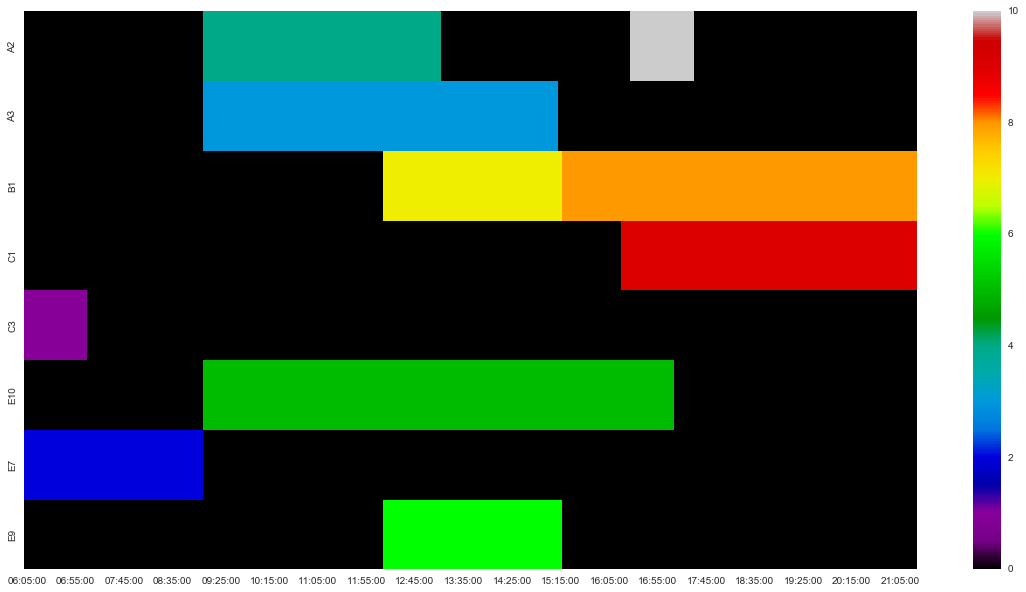

In [15]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

# We should have turn 7 and turn 8 assigned to same terminal (and possible gate)
for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))  

plot_gantt_chart(turns2, x)

## Model I - From soft-rule to hard-rule (k of N constraints hold)

The above example made the 'correct' assignment of those two turns favourable, however if our objective function was more complex and certain assignments had both negative and positive components, then (depending on the relative weighting) we may not get an assignment to the same terminal.

A way to ensure this would be to introduce it as a hard-constraint. For example:

`(Constraint-that-turn-7-goes-terminal-A AND Constraint-that-turn-8-goes-terminal-A)`

OR

`(Constraint-that-turn-7-goes-terminal-B AND Constraint-that-turn-8-goes-terminal-B)`

OR `... (for all terminals ...)` etc.

In our example, this can be written as:

`Constraint_1: turn_7_to_A1 + turn_7_to_A2 + turn_7_to_A3 + turn_8_to_A1 + turn_8_to_A2 + turn_8_to_A3 >= 2`

`Constraint_2: turn_7_to_B1 + turn_7_to_B2 + turn_7_to_B3 + turn_8_to_B1 + turn_8_to_B2 + turn_8_to_B3 >= 2`

Since a turn can only be assigned to one gate (given other constraints) we can set each constraint equal to two.

The issue is that **these are mutually exclusive constraints and we don't want to limit the model to just one of them**. This is an example of the **k out of N constraints must hold scenario**. For example, we can introduce y1, y2, y3 along with a constant M such that:

`Constraint_1: f1(x) >= b1 + M.y1`

`Constraint_2: f2(x) >= b2 + M.y2`

`Constraint_3: f3(x) >= b3 + M.y3`

`Constraint_4: y1 + y2 + y3 = N - k = 3 - 1 = 2`

Constraint_4 means that two of our binary y variables must be one ('switched-on') and one must be 0. In the example where N of N constraints must hold we get the scenario where y1, y2, and y3 are all 0. If we imagine that M is a large negative number and that y1 is the variable which is set to 0 we get the following scenario:

`Constraint_1: f1(x) >= b1`

`Constraint_2: f2(x) >= b2 - 1000000`

`Constraint_3: f3(x) >= b3 - 1000000`

Hence, we can see that constraint_2 and constraint_3 will be eliminated and only constraint_1 will hold. We can use the same tactic to make sure that same-terminal constraint is satisfied.

In [16]:
# 0. Initialise model
prob = LpProblem("Airport Gate Allocation", LpMinimize)  # minimize cost

# 1. Objective Function (ignore for now)
prob += 0

# 2. Variable: x[i,j] = (0,1)
# Binary = turn_i allocated to gate_j
x = {}
for t in turn_list:
    # For compatible gates
    for g in compatible_gates[t]:
        if g in occupancy.gate.get_values():
            
            t_dep = turns2.loc[turns2['turn_no']== t, 'outbound_departure'].values[0]
            t_arr = turns2.loc[turns2['turn_no']== t, 'inbound_arrival'].values[0]
            oc_from = occupancy.loc[occupancy['gate']== g, 'occupied_from'].values[0]
            oc_to = occupancy.loc[occupancy['gate']== g, 'occupied_to'].values[0]
            
            if (oc_to >= t_arr) and (oc_from <= t_dep):
                continue
                
        # Gate not occupied so create variable
        x[t, g] = LpVariable("t%i_g%s" % (t, g), 0, 1, LpBinary)

# 3. Constraints
# i. Each turn must be assigned to one compatible gate
for t in turn_list:
    prob += lpSum(x[t, g] for g in gate_list if (t, g) in x) == 1
    
# ii. Gates cannot have more than one turn/plane per time_bucket
for idx, row in heatmapdf.iterrows():
    # Get all the turns for time-bucket
    turns_in_time_bucket = set(dict(row[row==1]).keys())
    # For all gates
    for g in gate_list:
        # Constraints may be blank
        cons = [x[t, g] for t in turns_in_time_bucket if (t, g) in x]
        if len(cons) > 1:
            constraint_for_time_bucket = lpSum(cons) <= 1
            # These will occur when the plane overlaps change
            prob += constraint_for_time_bucket

In [17]:
extra_binary_var = {} # Dictionary to hold new variables

M = -1 * 1000000

# This time lets connect turn 7 to 8 and also 1 to 4
list_of_turns_to_be_connected = [(7,8),(1,4)]
list_of_terminals = airport2.terminal.unique()

for turn_i, turn_j in list_of_turns_to_be_connected:
    print("Creating constraints for turns: ", turn_i, turn_j)
    extra_constraint = []
    for airport_terminal in list_of_terminals:
        gates_in_terminal = airport2[airport2.terminal == airport_terminal].gate.unique()
        
        possible_allocations_i = [x[turn_i, gte] for gte in gates_in_terminal if (turn_i, gte) in x]
        possible_allocations_j = [x[turn_j, gte] for gte in gates_in_terminal if (turn_j, gte) in x]
        
        # If we have compatible gates in this terminal for both turns:
        if len(possible_allocations_i) and len(possible_allocations_j):      
            # Create new variable for constraints
            extra_binary_var[turn_i, turn_j, airport_terminal] = LpVariable("con_%s_t%i_t%i" %
                                                                            (airport_terminal, turn_i, turn_j), 
                                                                            0, 1, LpBinary)
            # Keep track of newly added variable
            extra_constraint.append(extra_binary_var[turn_i, turn_j, airport_terminal])
            cons = lpSum(possible_allocations_i + possible_allocations_j) >= 2 + \
            (M*extra_binary_var[turn_i, turn_j, airport_terminal])
            print(cons)
            prob += cons
    
    # k of N hold
    # In this example we have constraints for terminals A, B, C, and E so we set sum equal to 4-1=3
    cons = lpSum(extra_constraint) == len(extra_constraint) - 1
    print(cons)
    prob += cons

Creating constraints for turns:  7 8
1000000*con_A_t7_t8 + t7_gA1 + t8_gA1 + t8_gA2 >= 2
1000000*con_B_t7_t8 + t7_gB1 + t8_gB1 >= 2
1000000*con_C_t7_t8 + t7_gC4 + t8_gC1 + t8_gC2 + t8_gC3 + t8_gC4 >= 2
1000000*con_E_t7_t8 + t7_gE2 + t7_gE3 + t7_gE7 + t8_gE10 + t8_gE2 + t8_gE3 + t8_gE4 + t8_gE5 + t8_gE6 + t8_gE7 + t8_gE8 + t8_gE9 >= 2
con_A_t7_t8 + con_B_t7_t8 + con_C_t7_t8 + con_E_t7_t8 = 3
Creating constraints for turns:  1 4
1000000*con_A_t1_t4 + t1_gA1 + t1_gA3 + t4_gA1 + t4_gA2 + t4_gA3 >= 2
1000000*con_B_t1_t4 + t1_gB1 + t4_gB1 >= 2
1000000*con_C_t1_t4 + t1_gC3 + t1_gC4 + t4_gC1 + t4_gC2 + t4_gC3 + t4_gC4 >= 2
1000000*con_D_t1_t4 + t1_gD1 + t4_gD1 + t4_gE1 >= 2
1000000*con_E_t1_t4 + t1_gE10 + t1_gE2 + t1_gE3 + t1_gE6 + t1_gE7 + t1_gE8 + t4_gE10 + t4_gE2 + t4_gE3 + t4_gE4 + t4_gE5 + t4_gE6 + t4_gE7 + t4_gE8 + t4_gE9 >= 2
con_A_t1_t4 + con_B_t1_t4 + con_C_t1_t4 + con_D_t1_t4 + con_E_t1_t4 = 4


Status:  Optimal
Minimised Cost:  None
Turn 2 assigned to gate B1
Turn 9 assigned to gate E1
Turn 8 assigned to gate B1
Turn 4 assigned to gate E4
Turn 3 assigned to gate E3
Turn 7 assigned to gate B1
Turn 10 assigned to gate D1
Turn 6 assigned to gate C1
Turn 1 assigned to gate E6
Turn 5 assigned to gate C4


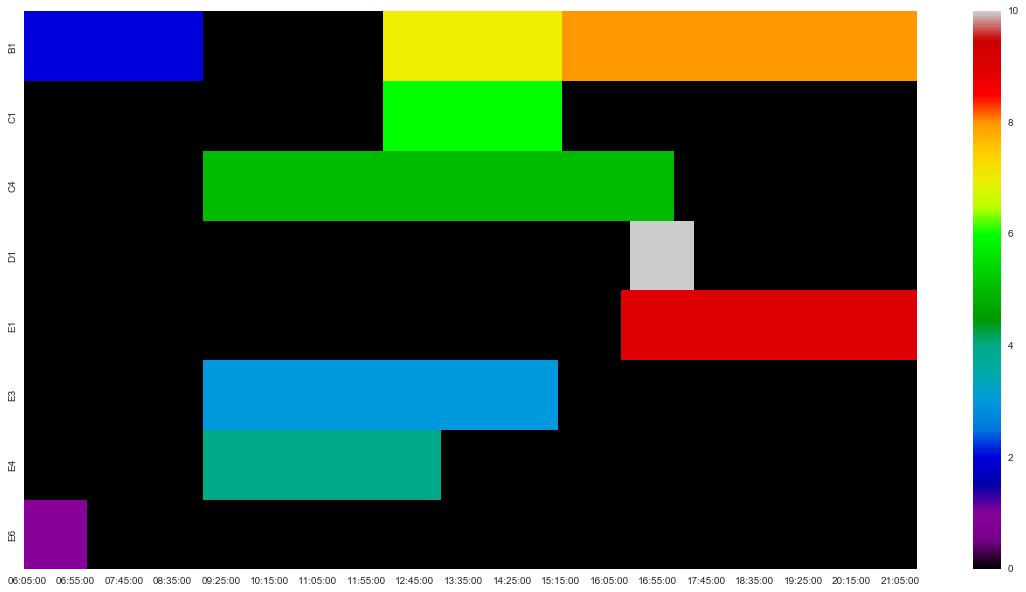

In [18]:
# Solve
prob.solve()

# Report
print("Status: ", LpStatus[prob.status])
print("Minimised Cost: ", value(prob.objective))

# We should have turn 7, 8 assigned to same terminal and also turns 1, 4
for alloc in x:
    if x[alloc].varValue:
        print("Turn %i assigned to gate %s" % (alloc[0], alloc[-1]))  

plot_gantt_chart(turns2, x)